In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Задание 1

In [2]:
# {'a': {'b': 10, 'c': 20}, 'b': {'a': 10, 'd': 20}, 'c': {'a': 20, 'd': 30}, 'd': {'b': 20, 'c': 30}}
# ['a', 'b', 'c', 'd'], np.array([[0, 10, 20, inf], [10, 0, inf, 20], [20, inf, 0, 30], [inf, 20, 30, 0]])

class Graph:
    def __init__(self):
        "Неориентированный взвешенный граф."
        
        self.graph = {}

    def add_node(self, v):
        "Добавление вершины с именем v."

        self.graph[v] = {}
    
    def set_edge(self, u, v, w):
        "Задание ребра весом w между u и v."
        
        self.graph[u][v] = w
        self.graph[v][u] = w

    def get_edge(self, u, v):
        "Получение веса ребра между u и v."
        
        return self.graph[u][v]

    def nodes(self):
        "Список вершин."
        
        return list(self.graph.keys())
    
    def is_connected(self):
        "Проверка связности."
        
        colors = [0] * len(self.nodes())

        return len(colors) == self._dfs(0, colors)

    def _dfs(self, node, colors):
        visited = 1
        colors[node] = 1
        neighbours = list(self.graph[self.nodes()[node]].keys())

        for neighbour in neighbours:
          if colors[self.nodes().index(neighbour)] == 0:
            visited += self._dfs(self.nodes().index(neighbour), colors)
        
        return visited
    

In [3]:
class Circuit(Graph):

    def probe_field(self, u, v, u_voltage=0, v_voltage=1):
        """
        Расчёт поля потенциалов при подключении источника тока в вершины u и v.
        Возвращает словарь {вершина: потенциал}.
        """

        # assert not self.is_connected() > 1, "Граф не является связным"

        u_index = self.nodes().index(u, 0, len(self.nodes()))
        v_index = self.nodes().index(v, 0, len(self.nodes()))

        resistances = self.nodes()
        resistances.pop(max(u_index, v_index))
        resistances.pop(min(u_index, v_index))
        
        a, b = self._equations(u, v, u_voltage, v_voltage, resistances)
        answer = np.linalg.solve(a, b)

        answer = np.insert(answer, u_index, u_voltage)
        answer = np.insert(answer, v_index, v_voltage)

        return answer
    
    def calculate_currents(self, voltages):
        """
        Расчёт значений токов, исходя из значений поля потенциалов.
        Возващает словарь {(вершина, вершина): ток}.
        """

        currents = {}
    
        for first in self.graph:
          for second in self.graph.get(first):
            current = (voltages[self.nodes().index(first)] - voltages[self.nodes().index(second)]) / (self.graph.get(first).get(second))
            currents[(first, second)] = current

        return currents
    
    def equivalent_resistance(self, u, v, u_voltage = 0, v_voltage = 1):
        """
        Расчёт эквивалентного сопротивления между вершинами u и v.
        """

        voltages = self.probe_field(u, v, u_voltage, v_voltage)
        currents = self.calculate_currents(voltages)
        current = 0

        for cur in currents:
          u_new, v_new = cur
          if currents[cur] > 0 and (u_new == u or v_new == v):
            current += currents[cur]

        return 2 * (u_voltage - v_voltage) / current
    
    def _equations(self, u, v, u_voltage, v_voltage, resistances):
        """
        Возвращает систему уравнений "Первое правило Кирхгофа".
        """

        a = []
        b = []

        for resistance in resistances:
          eq = np.zeros(len(resistances))
          number = 0
          neighbours = self.graph[resistance]

          for neighbour in neighbours:
            if neighbour == u:
              number += float(1) / self.get_edge(resistance, neighbour) * u_voltage
            elif neighbour == v:
              number += float(1) / self.get_edge(resistance, neighbour) * v_voltage
            else:
              index = resistances.index(neighbour)
              eq[index] -= float(1) / self.get_edge(resistance, neighbour)
            
            index = resistances.index(resistance)
            eq[index] += float(1) / self.get_edge(resistance, neighbour)
        
          a.append(eq)
          b.append(number)
        
        return np.array(a), np.array(b)

In [4]:
class Grid(Circuit):
    def __init__(self, width, height, resistance):
        """
        Прямоугольная решётка из width горизонтальных узлов и height вертикальных.
        """

        super().__init__()
        
        self.width = width
        self.height = height

        for i in range(height):
          for j in range(width):
            self.add_node((i, j))

        for i in range(height):
          for j in range(width):
            if i < height - 1:
              self.set_edge((i, j), (i + 1, j), resistance)
            if j < width - 1:
              self.set_edge((i, j), (i, j + 1), resistance)
    
    def plot_currents(self, currents):
        """
        Нарисовать картинку токов по заданному их распределению.
        """
        
        plt.xlim(-5, self.width + 5), plt.ylim(- 5, self.height + 5)

        max_current = max(currents.values())
        for node in currents:
          dot1, dot2 = node

          if currents[node] > 0:
            if dot1[0] == dot2[0]:
              if dot1[1] > dot2[1]:
                plt.arrow(dot1[0], dot1[1], 0, -1, width = 0.1, length_includes_head = True, alpha = currents[node] / max_current)
              else:
                plt.arrow(dot1[0], dot1[1], 0, 1, width = 0.1, length_includes_head = True, alpha = currents[node] / max_current)
            else:
              if dot1[0] > dot2[0]:
                plt.arrow(dot1[0], dot1[1], -1, 0, width = 0.1, length_includes_head = True, alpha = currents[node] / max_current)
              else:
                plt.arrow(dot1[0], dot1[1], 1, 0, width = 0.1, length_includes_head = True, alpha = currents[node] / max_current)
        
        plt.show()

        

#Задание 2

In [5]:
c = Circuit()
c.add_node('a')
c.add_node('b')
c.add_node('c')
c.add_node('d')
c.set_edge('a', 'b', 10)
c.set_edge('a', 'c', 20)
c.set_edge('b', 'd', 20)
c.set_edge('c', 'd', 30)
c.equivalent_resistance('a', 'd', 1, 0)

18.75

#Здание 3

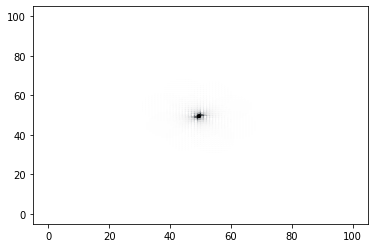

0.6367292137152665

In [6]:
g = Grid(100, 100, 1)
voltages = g.probe_field((49, 49), (50, 50), 1, 0)
currents = g.calculate_currents(voltages)
g.plot_currents(currents)
g.equivalent_resistance((49, 49), (50, 50), 1, 0)